## Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import helper


current_path = os.getcwd()
random_state = helper.RANDOM_STATE
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = helper.START_DATE
END_DATE = helper.END_DATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
stock_data = {}
for stock in STOCKS:
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    stock_data[stock] = data
stock_data = helper.preprocess_stock_data(stock_data, STOCKS)

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


## LSTM

In [72]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=False, bias=True)
        self.fc = nn.Linear(hidden_size, output_size) 
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.weight_decay = weight_decay 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        
        out = out.transpose(1, 2) 
        out = self.batchnorm(out)
        out = out.transpose(1, 2) 
        out = self.fc(out[:, -1, :])  
        return out
    def train_test_model(self, train_loader, test_loader, num_epochs=50, learning_rate=0.01):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        train_loss_history, test_loss_history = [], []
        best_test_loss = float('inf')
        
        for epoch in range(num_epochs):
            self.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            
            scheduler.step()  # Adjust the learning rate based on the scheduler
            average_train_loss = np.mean(train_losses)
            
            self.eval()
            test_losses = []
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self(inputs)
                    loss = criterion(outputs, targets)
                    test_losses.append(loss.item())
            average_test_loss = np.mean(test_losses)

            if average_test_loss < best_test_loss:
                best_test_loss = average_test_loss
                torch.save(self.state_dict(), 'best_model.pth')  # Save your model parameters

            train_loss_history.append(average_train_loss)
            test_loss_history.append(average_test_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}')
        
        return train_loss_history, test_loss_history
    

## Processing

In [73]:
stock = 'AAPL'
sequence_length=200
prediction_length=5
df_stock = stock_data[stock]

df_stock = df_stock[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 
                'WVAD', 'MACD',  'RSI', 'macd_line', 'signal_line', 'CCI', 
                'BB_Upper', 'BB_Lower', 'Buy_Signal', 'Sell_Signal', 
                'WVF_color', 'WVF', 'upperBand', 'rangeHigh'
            ]] 

dataToAdd = ['^IRX', 'SPY', 'QQQ', 'DIA'] # 'QQQ', "SPY", "MSFT", "AMZN", "GOOG",'DIA'
for item in dataToAdd:
    df_stock = df_stock.merge(stock_data[item][['Date', 'Close']], on="Date", how='inner', suffixes=("", f'_{item}'))

train_loader, test_loader, input_size, scaler_y = helper.prepare_data_and_model(df_stock, sequence_length=sequence_length, prediction_length=prediction_length, test_size=0.2)

input_size = input_size
hidden_size = 50
num_layers = 3
output_size = prediction_length
dropout_prob = 0.4
weight_decay = 0.001
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay).to(device)
train_loss_history, test_loss_history = model.train_test_model(train_loader, test_loader)

Date is not numerical or is the target variable
Epoch [1/50], Train Loss: 0.0189, Test Loss: 0.0235
Epoch [2/50], Train Loss: 0.0102, Test Loss: 0.0337
Epoch [3/50], Train Loss: 0.0099, Test Loss: 0.1238
Epoch [4/50], Train Loss: 0.0100, Test Loss: 0.1973
Epoch [5/50], Train Loss: 0.0094, Test Loss: 0.1594
Epoch [6/50], Train Loss: 0.0092, Test Loss: 0.2016
Epoch [7/50], Train Loss: 0.0085, Test Loss: 0.1862
Epoch [8/50], Train Loss: 0.0089, Test Loss: 0.1937
Epoch [9/50], Train Loss: 0.0086, Test Loss: 0.1817
Epoch [10/50], Train Loss: 0.0089, Test Loss: 0.1840
Epoch [11/50], Train Loss: 0.0137, Test Loss: 0.2459
Epoch [12/50], Train Loss: 0.0127, Test Loss: 0.2556
Epoch [13/50], Train Loss: 0.0121, Test Loss: 0.2397
Epoch [14/50], Train Loss: 0.0116, Test Loss: 0.2258
Epoch [15/50], Train Loss: 0.0110, Test Loss: 0.2106
Epoch [16/50], Train Loss: 0.0106, Test Loss: 0.2073
Epoch [17/50], Train Loss: 0.0102, Test Loss: 0.2019
Epoch [18/50], Train Loss: 0.0102, Test Loss: 0.2079
Epoch [

In [86]:
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval() 

StockPriceLSTM(
  (lstm): LSTM(54, 50, num_layers=3, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=50, out_features=5, bias=True)
  (batchnorm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
if len(df_stock) % 2 != 0:  # must be even
    df_stock = df_stock[:-1]
df_stock_swt = helper.apply_stationary_wavelet_transform(df_stock)
df_stock_swt = scaler.fit_transform(df_stock_swt)  

def rolling_window_sequences(data, window_size):
    shape = data.shape[:-1] + (data.shape[-1] - window_size + 1, window_size)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

rolling_windows = rolling_window_sequences(df_stock_swt, 200)
rolling_windows_tensor = torch.tensor(rolling_windows, dtype=torch.float32).to(device)
predictions = []
with torch.no_grad():
    for window in rolling_windows_tensor:
        window = window.unsqueeze(0)  # Add batch dimension
        prediction = model(window)
        predictions.append(prediction.cpu().numpy())

predictions = np.array(predictions).squeeze()

predicted_prices = scaler_y.inverse_transform(predictions)


Date is not numerical or is the target variable


ValueError: negative dimensions are not allowed

### without using rollingwindow

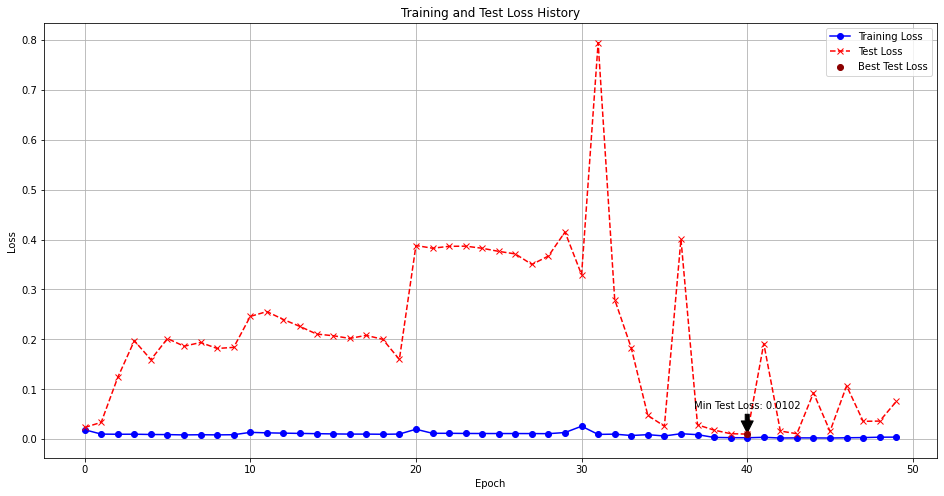

In [80]:
plt.figure(figsize=(16,8))
plt.plot(train_loss_history, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(test_loss_history, label='Test Loss', color='red', linestyle='--', marker='x')

min_test_loss = min(test_loss_history)
min_test_loss_index = test_loss_history.index(min_test_loss)
plt.scatter(min_test_loss_index, min_test_loss, color='darkred', label='Best Test Loss', zorder=5)

plt.annotate(f'Min Test Loss: {min_test_loss:.4f}',
             xy=(min_test_loss_index, min_test_loss),
             xytext=(min_test_loss_index, min_test_loss + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

# Training & Testing, rolling window

In [58]:
model = model.train_test_model(train_loader, test_loader, num_epochs=50, learning_rate=0.01)

RuntimeError: input.size(-1) must be equal to input_size. Expected 54, got 70

### Human level performance should be something around 75% in signal detection, professional traders

In [57]:
train_loader, test_loader, input_size, scaler_y = helper.prepare_data_and_model(stock_data[stock], sequence_length=sequence_length, prediction_length=prediction_length, test_size=0)
model = helper.train_test_model(model, train_loader, test_loader, 50)

Date is not numerical or is the target variable
rsi_class is not numerical or is the target variable


AttributeError: module 'helper' has no attribute 'train_test_model'

In [21]:
model.eval()
with torch.no_grad():
    predictions = []
    true = []
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        true.append(targets.cpu().numpy())
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
predictions = scaler_y.inverse_transform(predictions)

true = np.concatenate(true, axis=0)
true = scaler_y.inverse_transform(true)


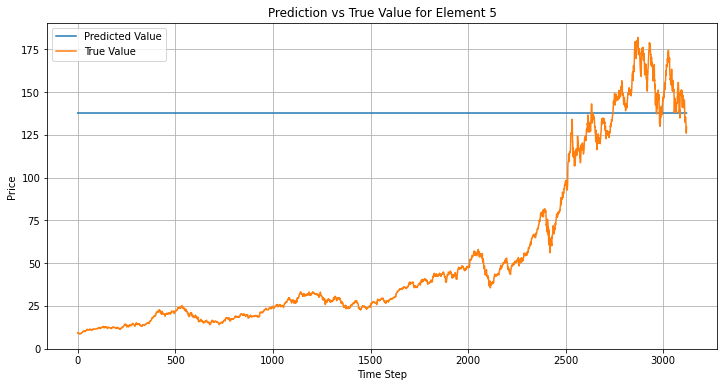

In [25]:
element_index = 4  # 0-based index

# Plot the prediction and true value for the 5th element
plt.figure(figsize=(12, 6))
plt.plot(predictions[:, element_index], label='Predicted Value')
plt.plot(true[:, element_index], label='True Value')
plt.title(f'Prediction vs True Value for Element {element_index + 1}')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()